In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Netlist import Circuit,SubCircuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Unit import *
from PySpice.Probe.Plot import plot
from PySpice.Logging.Logging import setup_logging
from multiprocessing import Pool
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
import random
setup_logging()

libraries_path = find_libraries()
spice_library = SpiceLibrary(libraries_path)

In [3]:
def generate_mn_range(M_start, M_end, N_start, N_end):
    special_mn = []
    for m in range(M_start, M_end+1):
        for n in range(N_start, N_end+1):
            special_mn.append((m, n))
    return special_mn

In [4]:
M = 364
N = 91
w = 0.0025
l = 0.0025

In [5]:
def create_tandem_array(M, N, special_mn):
    circuit = Circuit('Perovskite/Silicon Tandem Equivalent Circuit')
    
    circuit.model('D1_top', 'D', IS = 8.8e-23*(w*l), N =1)
    circuit.model('D2_top', 'D', IS = 2.62e-13*(w*l), N =2)
    circuit.model('D1_bot', 'D', IS=1.3339e-14*(w*l), N =1)
    circuit.model('D2_bot', 'D', IS=6.5674e-19*(w*l), N =2)
    circuit.V('1', 'input', circuit.gnd, 0@u_V)

    for m in range(M):
        for n in range(N):
            name_prefix = f"{m:03d}{n:03d}"
            is_special = (m, n) in special_mn
            print(f"Processing m={m}, n={n}, is_special={is_special}")
            
            # Metal Sheet Resistance
            if m == 0:
                circuit.R(f'Metal_sheet_input{n:03d}', 'input', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
            if ( m == 1 and 0 < n < 91) or (m > 1 and  n == 45):
                circuit.R(f'Metal_sheet_v{m:03d}{n:03d}', f'q{m-1:03d}{n:03d}', f'q{m:03d}{n:03d}', 2.13*l/w@u_mOhm)
                circuit.R(f'Metal_sheet_h{m:03d}{n:03d}', f'q{m:03d}{n-1:03d}', f'q{m:03d}{n:03d}', 2.13*w/l@u_mOhm)
                circuit.R(f'c_metal_{name_prefix}', f'q{m:03d}{n:03d}', f'a{m:03d}{n:03d}', 5/(w*l)@u_mOhm)            
            
                
            # ITO Sheet Resistance
            
            if m > 0:
                circuit.R(f'ITO_sheet_v{m:03d}{n:03d}', f'a{m-1:03d}{n:03d}', f'a{m:03d}{n:03d}', 55*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'ITO_sheet_h{m:03d}{n:03d}', f'a{m:03d}{n-1:03d}', f'a{m:03d}{n:03d}', 55*w/l@u_Ohm)

            # RJ Sheet Resistance
            if m > 0:
                circuit.R(f'RJ_sheet_v{m:03d}{n:03d}', f'd{m-1:03d}{n:02d}', f'd{m:03d}{n:03d}', 200*l/w@u_Ohm)
            if n > 0:
                circuit.R(f'RJ_sheet_h{m:03d}{n:03d}', f'd{m:03d}{n-1:03d}', f'd{m:03d}{n:03d}', 200*w/l@u_Ohm)

            # Top Cell
            
            circuit.R(f's_top_{name_prefix}', f'a{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
            circuit.D(f'1_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D1_top')
            circuit.D(f'2_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', model='D2_top')
            if is_special:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 2/(w*l)@u_Ohm)
                
            else:
                circuit.R(f'sh_top_{name_prefix}', f'b{m:03d}{n:03d}', f'c{m:03d}{n:03d}', 5.55/(w*l)@u_kOhm)
                
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_top_{name_prefix}', f'c{m:03d}{n:03d}', f'b{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

            # Connection
            circuit.R(f'c_top_{name_prefix}', f'c{m:03d}{n:03d}', f'd{m:03d}{n:03d}', 0/(w*l)@u_mOhm)
            circuit.R(f'c_bot_{name_prefix}', f'd{m:03d}{n:03d}', f'e{m:03d}{n:03d}', 0/(w*l)@u_mOhm)

            # Bottom Cell
            circuit.R(f's_bot_{name_prefix}', f'e{m:03d}{n:03d}', f'f{m:03d}{n:03d}', 0.2/(w*l)@u_Ohm)
            circuit.D(f'1_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D1_bot')
            circuit.D(f'2_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, model='D2_bot')
            circuit.R(f'sh_bot_{name_prefix}', f'f{m:03d}{n:03d}', circuit.gnd, 12/(w*l)@u_kOhm)
            if (m < 2 and n < 91) or (m > 1 and  n == 45):
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 0*(w*l)@u_mA)
            else:
                circuit.I(f'ph_bot_{name_prefix}', circuit.gnd, f'f{m:03d}{n:03d}', 19.65*(w*l)@u_mA)

    return circuit

In [6]:
M_start = 5
M_end = 19
N_start = 71
N_end = 85
special_mn = generate_mn_range(M_start, M_end, N_start, N_end)
circuit = create_tandem_array(M, N, special_mn)

def print_rsh_top_elements(circuit):
    count = 0
    for element in circuit.elements:
        if 'sh_top' in str(element.name):
            print(element)
            count += 1
    print(f"Total sh_top elements: {count}")

print_rsh_top_elements(circuit)


Processing m=0, n=0, is_special=False
Processing m=0, n=1, is_special=False
Processing m=0, n=2, is_special=False
Processing m=0, n=3, is_special=False
Processing m=0, n=4, is_special=False
Processing m=0, n=5, is_special=False
Processing m=0, n=6, is_special=False
Processing m=0, n=7, is_special=False
Processing m=0, n=8, is_special=False
Processing m=0, n=9, is_special=False
Processing m=0, n=10, is_special=False
Processing m=0, n=11, is_special=False
Processing m=0, n=12, is_special=False
Processing m=0, n=13, is_special=False
Processing m=0, n=14, is_special=False
Processing m=0, n=15, is_special=False
Processing m=0, n=16, is_special=False
Processing m=0, n=17, is_special=False
Processing m=0, n=18, is_special=False
Processing m=0, n=19, is_special=False
Processing m=0, n=20, is_special=False
Processing m=0, n=21, is_special=False
Processing m=0, n=22, is_special=False
Processing m=0, n=23, is_special=False
Processing m=0, n=24, is_special=False
Processing m=0, n=25, is_special=Fa

Processing m=11, n=62, is_special=False
Processing m=11, n=63, is_special=False
Processing m=11, n=64, is_special=False
Processing m=11, n=65, is_special=False
Processing m=11, n=66, is_special=False
Processing m=11, n=67, is_special=False
Processing m=11, n=68, is_special=False
Processing m=11, n=69, is_special=False
Processing m=11, n=70, is_special=False
Processing m=11, n=71, is_special=True
Processing m=11, n=72, is_special=True
Processing m=11, n=73, is_special=True
Processing m=11, n=74, is_special=True
Processing m=11, n=75, is_special=True
Processing m=11, n=76, is_special=True
Processing m=11, n=77, is_special=True
Processing m=11, n=78, is_special=True
Processing m=11, n=79, is_special=True
Processing m=11, n=80, is_special=True
Processing m=11, n=81, is_special=True
Processing m=11, n=82, is_special=True
Processing m=11, n=83, is_special=True
Processing m=11, n=84, is_special=True
Processing m=11, n=85, is_special=True
Processing m=11, n=86, is_special=False
Processing m=11

Processing m=22, n=56, is_special=False
Processing m=22, n=57, is_special=False
Processing m=22, n=58, is_special=False
Processing m=22, n=59, is_special=False
Processing m=22, n=60, is_special=False
Processing m=22, n=61, is_special=False
Processing m=22, n=62, is_special=False
Processing m=22, n=63, is_special=False
Processing m=22, n=64, is_special=False
Processing m=22, n=65, is_special=False
Processing m=22, n=66, is_special=False
Processing m=22, n=67, is_special=False
Processing m=22, n=68, is_special=False
Processing m=22, n=69, is_special=False
Processing m=22, n=70, is_special=False
Processing m=22, n=71, is_special=False
Processing m=22, n=72, is_special=False
Processing m=22, n=73, is_special=False
Processing m=22, n=74, is_special=False
Processing m=22, n=75, is_special=False
Processing m=22, n=76, is_special=False
Processing m=22, n=77, is_special=False
Processing m=22, n=78, is_special=False
Processing m=22, n=79, is_special=False
Processing m=22, n=80, is_special=False


Processing m=35, n=2, is_special=False
Processing m=35, n=3, is_special=False
Processing m=35, n=4, is_special=False
Processing m=35, n=5, is_special=False
Processing m=35, n=6, is_special=False
Processing m=35, n=7, is_special=False
Processing m=35, n=8, is_special=False
Processing m=35, n=9, is_special=False
Processing m=35, n=10, is_special=False
Processing m=35, n=11, is_special=False
Processing m=35, n=12, is_special=False
Processing m=35, n=13, is_special=False
Processing m=35, n=14, is_special=False
Processing m=35, n=15, is_special=False
Processing m=35, n=16, is_special=False
Processing m=35, n=17, is_special=False
Processing m=35, n=18, is_special=False
Processing m=35, n=19, is_special=False
Processing m=35, n=20, is_special=False
Processing m=35, n=21, is_special=False
Processing m=35, n=22, is_special=False
Processing m=35, n=23, is_special=False
Processing m=35, n=24, is_special=False
Processing m=35, n=25, is_special=False
Processing m=35, n=26, is_special=False
Processi

Processing m=48, n=51, is_special=False
Processing m=48, n=52, is_special=False
Processing m=48, n=53, is_special=False
Processing m=48, n=54, is_special=False
Processing m=48, n=55, is_special=False
Processing m=48, n=56, is_special=False
Processing m=48, n=57, is_special=False
Processing m=48, n=58, is_special=False
Processing m=48, n=59, is_special=False
Processing m=48, n=60, is_special=False
Processing m=48, n=61, is_special=False
Processing m=48, n=62, is_special=False
Processing m=48, n=63, is_special=False
Processing m=48, n=64, is_special=False
Processing m=48, n=65, is_special=False
Processing m=48, n=66, is_special=False
Processing m=48, n=67, is_special=False
Processing m=48, n=68, is_special=False
Processing m=48, n=69, is_special=False
Processing m=48, n=70, is_special=False
Processing m=48, n=71, is_special=False
Processing m=48, n=72, is_special=False
Processing m=48, n=73, is_special=False
Processing m=48, n=74, is_special=False
Processing m=48, n=75, is_special=False


Processing m=59, n=78, is_special=False
Processing m=59, n=79, is_special=False
Processing m=59, n=80, is_special=False
Processing m=59, n=81, is_special=False
Processing m=59, n=82, is_special=False
Processing m=59, n=83, is_special=False
Processing m=59, n=84, is_special=False
Processing m=59, n=85, is_special=False
Processing m=59, n=86, is_special=False
Processing m=59, n=87, is_special=False
Processing m=59, n=88, is_special=False
Processing m=59, n=89, is_special=False
Processing m=59, n=90, is_special=False
Processing m=60, n=0, is_special=False
Processing m=60, n=1, is_special=False
Processing m=60, n=2, is_special=False
Processing m=60, n=3, is_special=False
Processing m=60, n=4, is_special=False
Processing m=60, n=5, is_special=False
Processing m=60, n=6, is_special=False
Processing m=60, n=7, is_special=False
Processing m=60, n=8, is_special=False
Processing m=60, n=9, is_special=False
Processing m=60, n=10, is_special=False
Processing m=60, n=11, is_special=False
Processing

Processing m=74, n=38, is_special=False
Processing m=74, n=39, is_special=False
Processing m=74, n=40, is_special=False
Processing m=74, n=41, is_special=False
Processing m=74, n=42, is_special=False
Processing m=74, n=43, is_special=False
Processing m=74, n=44, is_special=False
Processing m=74, n=45, is_special=False
Processing m=74, n=46, is_special=False
Processing m=74, n=47, is_special=False
Processing m=74, n=48, is_special=False
Processing m=74, n=49, is_special=False
Processing m=74, n=50, is_special=False
Processing m=74, n=51, is_special=False
Processing m=74, n=52, is_special=False
Processing m=74, n=53, is_special=False
Processing m=74, n=54, is_special=False
Processing m=74, n=55, is_special=False
Processing m=74, n=56, is_special=False
Processing m=74, n=57, is_special=False
Processing m=74, n=58, is_special=False
Processing m=74, n=59, is_special=False
Processing m=74, n=60, is_special=False
Processing m=74, n=61, is_special=False
Processing m=74, n=62, is_special=False


Processing m=89, n=17, is_special=False
Processing m=89, n=18, is_special=False
Processing m=89, n=19, is_special=False
Processing m=89, n=20, is_special=False
Processing m=89, n=21, is_special=False
Processing m=89, n=22, is_special=False
Processing m=89, n=23, is_special=False
Processing m=89, n=24, is_special=False
Processing m=89, n=25, is_special=False
Processing m=89, n=26, is_special=False
Processing m=89, n=27, is_special=False
Processing m=89, n=28, is_special=False
Processing m=89, n=29, is_special=False
Processing m=89, n=30, is_special=False
Processing m=89, n=31, is_special=False
Processing m=89, n=32, is_special=False
Processing m=89, n=33, is_special=False
Processing m=89, n=34, is_special=False
Processing m=89, n=35, is_special=False
Processing m=89, n=36, is_special=False
Processing m=89, n=37, is_special=False
Processing m=89, n=38, is_special=False
Processing m=89, n=39, is_special=False
Processing m=89, n=40, is_special=False
Processing m=89, n=41, is_special=False


Processing m=98, n=53, is_special=False
Processing m=98, n=54, is_special=False
Processing m=98, n=55, is_special=False
Processing m=98, n=56, is_special=False
Processing m=98, n=57, is_special=False
Processing m=98, n=58, is_special=False
Processing m=98, n=59, is_special=False
Processing m=98, n=60, is_special=False
Processing m=98, n=61, is_special=False
Processing m=98, n=62, is_special=False
Processing m=98, n=63, is_special=False
Processing m=98, n=64, is_special=False
Processing m=98, n=65, is_special=False
Processing m=98, n=66, is_special=False
Processing m=98, n=67, is_special=False
Processing m=98, n=68, is_special=False
Processing m=98, n=69, is_special=False
Processing m=98, n=70, is_special=False
Processing m=98, n=71, is_special=False
Processing m=98, n=72, is_special=False
Processing m=98, n=73, is_special=False
Processing m=98, n=74, is_special=False
Processing m=98, n=75, is_special=False
Processing m=98, n=76, is_special=False
Processing m=98, n=77, is_special=False


Processing m=116, n=54, is_special=False
Processing m=116, n=55, is_special=False
Processing m=116, n=56, is_special=False
Processing m=116, n=57, is_special=False
Processing m=116, n=58, is_special=False
Processing m=116, n=59, is_special=False
Processing m=116, n=60, is_special=False
Processing m=116, n=61, is_special=False
Processing m=116, n=62, is_special=False
Processing m=116, n=63, is_special=False
Processing m=116, n=64, is_special=False
Processing m=116, n=65, is_special=False
Processing m=116, n=66, is_special=False
Processing m=116, n=67, is_special=False
Processing m=116, n=68, is_special=False
Processing m=116, n=69, is_special=False
Processing m=116, n=70, is_special=False
Processing m=116, n=71, is_special=False
Processing m=116, n=72, is_special=False
Processing m=116, n=73, is_special=False
Processing m=116, n=74, is_special=False
Processing m=116, n=75, is_special=False
Processing m=116, n=76, is_special=False
Processing m=116, n=77, is_special=False
Processing m=116

Processing m=130, n=30, is_special=False
Processing m=130, n=31, is_special=False
Processing m=130, n=32, is_special=False
Processing m=130, n=33, is_special=False
Processing m=130, n=34, is_special=False
Processing m=130, n=35, is_special=False
Processing m=130, n=36, is_special=False
Processing m=130, n=37, is_special=False
Processing m=130, n=38, is_special=False
Processing m=130, n=39, is_special=False
Processing m=130, n=40, is_special=False
Processing m=130, n=41, is_special=False
Processing m=130, n=42, is_special=False
Processing m=130, n=43, is_special=False
Processing m=130, n=44, is_special=False
Processing m=130, n=45, is_special=False
Processing m=130, n=46, is_special=False
Processing m=130, n=47, is_special=False
Processing m=130, n=48, is_special=False
Processing m=130, n=49, is_special=False
Processing m=130, n=50, is_special=False
Processing m=130, n=51, is_special=False
Processing m=130, n=52, is_special=False
Processing m=130, n=53, is_special=False
Processing m=130

Processing m=153, n=77, is_special=False
Processing m=153, n=78, is_special=False
Processing m=153, n=79, is_special=False
Processing m=153, n=80, is_special=False
Processing m=153, n=81, is_special=False
Processing m=153, n=82, is_special=False
Processing m=153, n=83, is_special=False
Processing m=153, n=84, is_special=False
Processing m=153, n=85, is_special=False
Processing m=153, n=86, is_special=False
Processing m=153, n=87, is_special=False
Processing m=153, n=88, is_special=False
Processing m=153, n=89, is_special=False
Processing m=153, n=90, is_special=False
Processing m=154, n=0, is_special=False
Processing m=154, n=1, is_special=False
Processing m=154, n=2, is_special=False
Processing m=154, n=3, is_special=False
Processing m=154, n=4, is_special=False
Processing m=154, n=5, is_special=False
Processing m=154, n=6, is_special=False
Processing m=154, n=7, is_special=False
Processing m=154, n=8, is_special=False
Processing m=154, n=9, is_special=False
Processing m=154, n=10, is

Processing m=159, n=60, is_special=False
Processing m=159, n=61, is_special=False
Processing m=159, n=62, is_special=False
Processing m=159, n=63, is_special=False
Processing m=159, n=64, is_special=False
Processing m=159, n=65, is_special=False
Processing m=159, n=66, is_special=False
Processing m=159, n=67, is_special=False
Processing m=159, n=68, is_special=False
Processing m=159, n=69, is_special=False
Processing m=159, n=70, is_special=False
Processing m=159, n=71, is_special=False
Processing m=159, n=72, is_special=False
Processing m=159, n=73, is_special=False
Processing m=159, n=74, is_special=False
Processing m=159, n=75, is_special=False
Processing m=159, n=76, is_special=False
Processing m=159, n=77, is_special=False
Processing m=159, n=78, is_special=False
Processing m=159, n=79, is_special=False
Processing m=159, n=80, is_special=False
Processing m=159, n=81, is_special=False
Processing m=159, n=82, is_special=False
Processing m=159, n=83, is_special=False
Processing m=159

Processing m=182, n=62, is_special=False
Processing m=182, n=63, is_special=False
Processing m=182, n=64, is_special=False
Processing m=182, n=65, is_special=False
Processing m=182, n=66, is_special=False
Processing m=182, n=67, is_special=False
Processing m=182, n=68, is_special=False
Processing m=182, n=69, is_special=False
Processing m=182, n=70, is_special=False
Processing m=182, n=71, is_special=False
Processing m=182, n=72, is_special=False
Processing m=182, n=73, is_special=False
Processing m=182, n=74, is_special=False
Processing m=182, n=75, is_special=False
Processing m=182, n=76, is_special=False
Processing m=182, n=77, is_special=False
Processing m=182, n=78, is_special=False
Processing m=182, n=79, is_special=False
Processing m=182, n=80, is_special=False
Processing m=182, n=81, is_special=False
Processing m=182, n=82, is_special=False
Processing m=182, n=83, is_special=False
Processing m=182, n=84, is_special=False
Processing m=182, n=85, is_special=False
Processing m=182

Processing m=197, n=90, is_special=False
Processing m=198, n=0, is_special=False
Processing m=198, n=1, is_special=False
Processing m=198, n=2, is_special=False
Processing m=198, n=3, is_special=False
Processing m=198, n=4, is_special=False
Processing m=198, n=5, is_special=False
Processing m=198, n=6, is_special=False
Processing m=198, n=7, is_special=False
Processing m=198, n=8, is_special=False
Processing m=198, n=9, is_special=False
Processing m=198, n=10, is_special=False
Processing m=198, n=11, is_special=False
Processing m=198, n=12, is_special=False
Processing m=198, n=13, is_special=False
Processing m=198, n=14, is_special=False
Processing m=198, n=15, is_special=False
Processing m=198, n=16, is_special=False
Processing m=198, n=17, is_special=False
Processing m=198, n=18, is_special=False
Processing m=198, n=19, is_special=False
Processing m=198, n=20, is_special=False
Processing m=198, n=21, is_special=False
Processing m=198, n=22, is_special=False
Processing m=198, n=23, is

Processing m=201, n=77, is_special=False
Processing m=201, n=78, is_special=False
Processing m=201, n=79, is_special=False
Processing m=201, n=80, is_special=False
Processing m=201, n=81, is_special=False
Processing m=201, n=82, is_special=False
Processing m=201, n=83, is_special=False
Processing m=201, n=84, is_special=False
Processing m=201, n=85, is_special=False
Processing m=201, n=86, is_special=False
Processing m=201, n=87, is_special=False
Processing m=201, n=88, is_special=False
Processing m=201, n=89, is_special=False
Processing m=201, n=90, is_special=False
Processing m=202, n=0, is_special=False
Processing m=202, n=1, is_special=False
Processing m=202, n=2, is_special=False
Processing m=202, n=3, is_special=False
Processing m=202, n=4, is_special=False
Processing m=202, n=5, is_special=False
Processing m=202, n=6, is_special=False
Processing m=202, n=7, is_special=False
Processing m=202, n=8, is_special=False
Processing m=202, n=9, is_special=False
Processing m=202, n=10, is

Processing m=219, n=33, is_special=False
Processing m=219, n=34, is_special=False
Processing m=219, n=35, is_special=False
Processing m=219, n=36, is_special=False
Processing m=219, n=37, is_special=False
Processing m=219, n=38, is_special=False
Processing m=219, n=39, is_special=False
Processing m=219, n=40, is_special=False
Processing m=219, n=41, is_special=False
Processing m=219, n=42, is_special=False
Processing m=219, n=43, is_special=False
Processing m=219, n=44, is_special=False
Processing m=219, n=45, is_special=False
Processing m=219, n=46, is_special=False
Processing m=219, n=47, is_special=False
Processing m=219, n=48, is_special=False
Processing m=219, n=49, is_special=False
Processing m=219, n=50, is_special=False
Processing m=219, n=51, is_special=False
Processing m=219, n=52, is_special=False
Processing m=219, n=53, is_special=False
Processing m=219, n=54, is_special=False
Processing m=219, n=55, is_special=False
Processing m=219, n=56, is_special=False
Processing m=219

Processing m=234, n=0, is_special=False
Processing m=234, n=1, is_special=False
Processing m=234, n=2, is_special=False
Processing m=234, n=3, is_special=False
Processing m=234, n=4, is_special=False
Processing m=234, n=5, is_special=False
Processing m=234, n=6, is_special=False
Processing m=234, n=7, is_special=False
Processing m=234, n=8, is_special=False
Processing m=234, n=9, is_special=False
Processing m=234, n=10, is_special=False
Processing m=234, n=11, is_special=False
Processing m=234, n=12, is_special=False
Processing m=234, n=13, is_special=False
Processing m=234, n=14, is_special=False
Processing m=234, n=15, is_special=False
Processing m=234, n=16, is_special=False
Processing m=234, n=17, is_special=False
Processing m=234, n=18, is_special=False
Processing m=234, n=19, is_special=False
Processing m=234, n=20, is_special=False
Processing m=234, n=21, is_special=False
Processing m=234, n=22, is_special=False
Processing m=234, n=23, is_special=False
Processing m=234, n=24, is

Processing m=247, n=53, is_special=False
Processing m=247, n=54, is_special=False
Processing m=247, n=55, is_special=False
Processing m=247, n=56, is_special=False
Processing m=247, n=57, is_special=False
Processing m=247, n=58, is_special=False
Processing m=247, n=59, is_special=False
Processing m=247, n=60, is_special=False
Processing m=247, n=61, is_special=False
Processing m=247, n=62, is_special=False
Processing m=247, n=63, is_special=False
Processing m=247, n=64, is_special=False
Processing m=247, n=65, is_special=False
Processing m=247, n=66, is_special=False
Processing m=247, n=67, is_special=False
Processing m=247, n=68, is_special=False
Processing m=247, n=69, is_special=False
Processing m=247, n=70, is_special=False
Processing m=247, n=71, is_special=False
Processing m=247, n=72, is_special=False
Processing m=247, n=73, is_special=False
Processing m=247, n=74, is_special=False
Processing m=247, n=75, is_special=False
Processing m=247, n=76, is_special=False
Processing m=247

Processing m=255, n=55, is_special=False
Processing m=255, n=56, is_special=False
Processing m=255, n=57, is_special=False
Processing m=255, n=58, is_special=False
Processing m=255, n=59, is_special=False
Processing m=255, n=60, is_special=False
Processing m=255, n=61, is_special=False
Processing m=255, n=62, is_special=False
Processing m=255, n=63, is_special=False
Processing m=255, n=64, is_special=False
Processing m=255, n=65, is_special=False
Processing m=255, n=66, is_special=False
Processing m=255, n=67, is_special=False
Processing m=255, n=68, is_special=False
Processing m=255, n=69, is_special=False
Processing m=255, n=70, is_special=False
Processing m=255, n=71, is_special=False
Processing m=255, n=72, is_special=False
Processing m=255, n=73, is_special=False
Processing m=255, n=74, is_special=False
Processing m=255, n=75, is_special=False
Processing m=255, n=76, is_special=False
Processing m=255, n=77, is_special=False
Processing m=255, n=78, is_special=False
Processing m=255

Processing m=272, n=44, is_special=False
Processing m=272, n=45, is_special=False
Processing m=272, n=46, is_special=False
Processing m=272, n=47, is_special=False
Processing m=272, n=48, is_special=False
Processing m=272, n=49, is_special=False
Processing m=272, n=50, is_special=False
Processing m=272, n=51, is_special=False
Processing m=272, n=52, is_special=False
Processing m=272, n=53, is_special=False
Processing m=272, n=54, is_special=False
Processing m=272, n=55, is_special=False
Processing m=272, n=56, is_special=False
Processing m=272, n=57, is_special=False
Processing m=272, n=58, is_special=False
Processing m=272, n=59, is_special=False
Processing m=272, n=60, is_special=False
Processing m=272, n=61, is_special=False
Processing m=272, n=62, is_special=False
Processing m=272, n=63, is_special=False
Processing m=272, n=64, is_special=False
Processing m=272, n=65, is_special=False
Processing m=272, n=66, is_special=False
Processing m=272, n=67, is_special=False
Processing m=272

Processing m=287, n=84, is_special=False
Processing m=287, n=85, is_special=False
Processing m=287, n=86, is_special=False
Processing m=287, n=87, is_special=False
Processing m=287, n=88, is_special=False
Processing m=287, n=89, is_special=False
Processing m=287, n=90, is_special=False
Processing m=288, n=0, is_special=False
Processing m=288, n=1, is_special=False
Processing m=288, n=2, is_special=False
Processing m=288, n=3, is_special=False
Processing m=288, n=4, is_special=False
Processing m=288, n=5, is_special=False
Processing m=288, n=6, is_special=False
Processing m=288, n=7, is_special=False
Processing m=288, n=8, is_special=False
Processing m=288, n=9, is_special=False
Processing m=288, n=10, is_special=False
Processing m=288, n=11, is_special=False
Processing m=288, n=12, is_special=False
Processing m=288, n=13, is_special=False
Processing m=288, n=14, is_special=False
Processing m=288, n=15, is_special=False
Processing m=288, n=16, is_special=False
Processing m=288, n=17, is

Processing m=306, n=23, is_special=False
Processing m=306, n=24, is_special=False
Processing m=306, n=25, is_special=False
Processing m=306, n=26, is_special=False
Processing m=306, n=27, is_special=False
Processing m=306, n=28, is_special=False
Processing m=306, n=29, is_special=False
Processing m=306, n=30, is_special=False
Processing m=306, n=31, is_special=False
Processing m=306, n=32, is_special=False
Processing m=306, n=33, is_special=False
Processing m=306, n=34, is_special=False
Processing m=306, n=35, is_special=False
Processing m=306, n=36, is_special=False
Processing m=306, n=37, is_special=False
Processing m=306, n=38, is_special=False
Processing m=306, n=39, is_special=False
Processing m=306, n=40, is_special=False
Processing m=306, n=41, is_special=False
Processing m=306, n=42, is_special=False
Processing m=306, n=43, is_special=False
Processing m=306, n=44, is_special=False
Processing m=306, n=45, is_special=False
Processing m=306, n=46, is_special=False
Processing m=306

Processing m=322, n=12, is_special=False
Processing m=322, n=13, is_special=False
Processing m=322, n=14, is_special=False
Processing m=322, n=15, is_special=False
Processing m=322, n=16, is_special=False
Processing m=322, n=17, is_special=False
Processing m=322, n=18, is_special=False
Processing m=322, n=19, is_special=False
Processing m=322, n=20, is_special=False
Processing m=322, n=21, is_special=False
Processing m=322, n=22, is_special=False
Processing m=322, n=23, is_special=False
Processing m=322, n=24, is_special=False
Processing m=322, n=25, is_special=False
Processing m=322, n=26, is_special=False
Processing m=322, n=27, is_special=False
Processing m=322, n=28, is_special=False
Processing m=322, n=29, is_special=False
Processing m=322, n=30, is_special=False
Processing m=322, n=31, is_special=False
Processing m=322, n=32, is_special=False
Processing m=322, n=33, is_special=False
Processing m=322, n=34, is_special=False
Processing m=322, n=35, is_special=False
Processing m=322

Processing m=338, n=56, is_special=False
Processing m=338, n=57, is_special=False
Processing m=338, n=58, is_special=False
Processing m=338, n=59, is_special=False
Processing m=338, n=60, is_special=False
Processing m=338, n=61, is_special=False
Processing m=338, n=62, is_special=False
Processing m=338, n=63, is_special=False
Processing m=338, n=64, is_special=False
Processing m=338, n=65, is_special=False
Processing m=338, n=66, is_special=False
Processing m=338, n=67, is_special=False
Processing m=338, n=68, is_special=False
Processing m=338, n=69, is_special=False
Processing m=338, n=70, is_special=False
Processing m=338, n=71, is_special=False
Processing m=338, n=72, is_special=False
Processing m=338, n=73, is_special=False
Processing m=338, n=74, is_special=False
Processing m=338, n=75, is_special=False
Processing m=338, n=76, is_special=False
Processing m=338, n=77, is_special=False
Processing m=338, n=78, is_special=False
Processing m=338, n=79, is_special=False
Processing m=338

Processing m=353, n=63, is_special=False
Processing m=353, n=64, is_special=False
Processing m=353, n=65, is_special=False
Processing m=353, n=66, is_special=False
Processing m=353, n=67, is_special=False
Processing m=353, n=68, is_special=False
Processing m=353, n=69, is_special=False
Processing m=353, n=70, is_special=False
Processing m=353, n=71, is_special=False
Processing m=353, n=72, is_special=False
Processing m=353, n=73, is_special=False
Processing m=353, n=74, is_special=False
Processing m=353, n=75, is_special=False
Processing m=353, n=76, is_special=False
Processing m=353, n=77, is_special=False
Processing m=353, n=78, is_special=False
Processing m=353, n=79, is_special=False
Processing m=353, n=80, is_special=False
Processing m=353, n=81, is_special=False
Processing m=353, n=82, is_special=False
Processing m=353, n=83, is_special=False
Processing m=353, n=84, is_special=False
Processing m=353, n=85, is_special=False
Processing m=353, n=86, is_special=False
Processing m=353

Rsh_top_049090 b049090 c049090 887999.9999999999kOhm
Rsh_top_050000 b050000 c050000 887999.9999999999kOhm
Rsh_top_050001 b050001 c050001 887999.9999999999kOhm
Rsh_top_050002 b050002 c050002 887999.9999999999kOhm
Rsh_top_050003 b050003 c050003 887999.9999999999kOhm
Rsh_top_050004 b050004 c050004 887999.9999999999kOhm
Rsh_top_050005 b050005 c050005 887999.9999999999kOhm
Rsh_top_050006 b050006 c050006 887999.9999999999kOhm
Rsh_top_050007 b050007 c050007 887999.9999999999kOhm
Rsh_top_050008 b050008 c050008 887999.9999999999kOhm
Rsh_top_050009 b050009 c050009 887999.9999999999kOhm
Rsh_top_050010 b050010 c050010 887999.9999999999kOhm
Rsh_top_050011 b050011 c050011 887999.9999999999kOhm
Rsh_top_050012 b050012 c050012 887999.9999999999kOhm
Rsh_top_050013 b050013 c050013 887999.9999999999kOhm
Rsh_top_050014 b050014 c050014 887999.9999999999kOhm
Rsh_top_050015 b050015 c050015 887999.9999999999kOhm
Rsh_top_050016 b050016 c050016 887999.9999999999kOhm
Rsh_top_050017 b050017 c050017 887999.99999999

Rsh_top_172005 b172005 c172005 887999.9999999999kOhm
Rsh_top_172006 b172006 c172006 887999.9999999999kOhm
Rsh_top_172007 b172007 c172007 887999.9999999999kOhm
Rsh_top_172008 b172008 c172008 887999.9999999999kOhm
Rsh_top_172009 b172009 c172009 887999.9999999999kOhm
Rsh_top_172010 b172010 c172010 887999.9999999999kOhm
Rsh_top_172011 b172011 c172011 887999.9999999999kOhm
Rsh_top_172012 b172012 c172012 887999.9999999999kOhm
Rsh_top_172013 b172013 c172013 887999.9999999999kOhm
Rsh_top_172014 b172014 c172014 887999.9999999999kOhm
Rsh_top_172015 b172015 c172015 887999.9999999999kOhm
Rsh_top_172016 b172016 c172016 887999.9999999999kOhm
Rsh_top_172017 b172017 c172017 887999.9999999999kOhm
Rsh_top_172018 b172018 c172018 887999.9999999999kOhm
Rsh_top_172019 b172019 c172019 887999.9999999999kOhm
Rsh_top_172020 b172020 c172020 887999.9999999999kOhm
Rsh_top_172021 b172021 c172021 887999.9999999999kOhm
Rsh_top_172022 b172022 c172022 887999.9999999999kOhm
Rsh_top_172023 b172023 c172023 887999.99999999

Rsh_top_278040 b278040 c278040 887999.9999999999kOhm
Rsh_top_278041 b278041 c278041 887999.9999999999kOhm
Rsh_top_278042 b278042 c278042 887999.9999999999kOhm
Rsh_top_278043 b278043 c278043 887999.9999999999kOhm
Rsh_top_278044 b278044 c278044 887999.9999999999kOhm
Rsh_top_278045 b278045 c278045 887999.9999999999kOhm
Rsh_top_278046 b278046 c278046 887999.9999999999kOhm
Rsh_top_278047 b278047 c278047 887999.9999999999kOhm
Rsh_top_278048 b278048 c278048 887999.9999999999kOhm
Rsh_top_278049 b278049 c278049 887999.9999999999kOhm
Rsh_top_278050 b278050 c278050 887999.9999999999kOhm
Rsh_top_278051 b278051 c278051 887999.9999999999kOhm
Rsh_top_278052 b278052 c278052 887999.9999999999kOhm
Rsh_top_278053 b278053 c278053 887999.9999999999kOhm
Rsh_top_278054 b278054 c278054 887999.9999999999kOhm
Rsh_top_278055 b278055 c278055 887999.9999999999kOhm
Rsh_top_278056 b278056 c278056 887999.9999999999kOhm
Rsh_top_278057 b278057 c278057 887999.9999999999kOhm
Rsh_top_278058 b278058 c278058 887999.99999999

CPU times: total: 1h 58min 12s
Wall time: 2h 43min 12s
2023-08-29 12:31:57,480 - matplotlib.legend - legend.WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


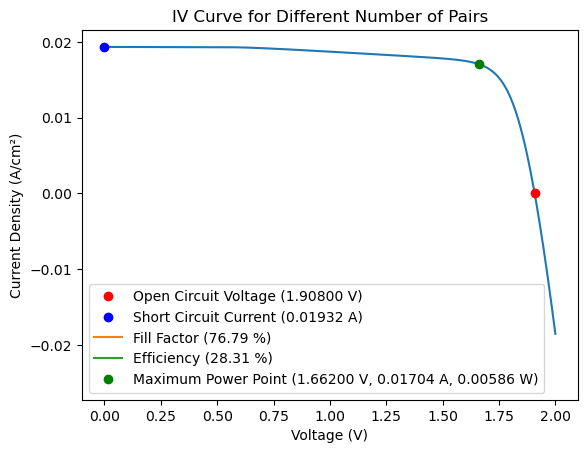

In [7]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
%time analysis = simulator.dc(V1=slice(0, 2, 0.001))
voltage = analysis.nodes['input'].as_ndarray()  # analysis: a dictionary of measured values from nodes and branches
current = analysis.branches['v1'].as_ndarray()  # as_ndarray: converts measured values from a specific node or branch into a numpy array
normalized_current = current / (w * l * M *N)

# Calculate open circuit voltage
v_oc_index = np.argmin(np.abs(normalized_current))  # abs: function that returns the absolute value of a given number
v_oc = voltage[v_oc_index]  # argmin: returns the index of the minimum element in the numpy array

# Calculate short circuit current
i_sc_index = np.argmin(np.abs(voltage))
i_sc = normalized_current[i_sc_index]

# Calculate Maximum Power Point
power = voltage * current
mpp_index = np.argmax(power)
v_mpp = voltage[mpp_index]
i_mpp = normalized_current[mpp_index]
max_power = power[mpp_index]
efficiency = (max_power/(0.1*w*l*M*N))*100

# Calculate Fill Factor
fill_factor = (v_mpp * i_mpp) / (v_oc * i_sc)

plt.plot(voltage, normalized_current)

plt.legend()
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/cm²)')
plt.title('IV Curve for Different Number of Pairs')

# 오픈 회로 전압과 단락 전류 표시
plt.plot(v_oc, 0, 'ro', label=f'Open Circuit Voltage ({v_oc:.5f} V)')
plt.plot(0, i_sc, 'bo', label=f'Short Circuit Current ({i_sc:.5f} A)')
plt.plot(0, -0.025, label=f'Fill Factor ({fill_factor*100:.2f} %)')
plt.plot(0, -0.02, label=f'Efficiency ({efficiency:.2f} %)')
# 최대 전력 지점 표시
plt.plot(v_mpp, i_mpp, 'go', label=f'Maximum Power Point ({v_mpp:.5f} V, {i_mpp:.5f} A, {max_power:.5f} W)')

plt.legend()

plt.show()

In [8]:
print(circuit)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

